In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', 50)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


# Exploratory Data Analysis (EDA)

## Reading the CSV files

First I am going to read the CSV files. 

In [2]:
# Train Dataset
train_df = pd.read_csv('../input/playground-series-s5e11/train.csv')
# Test Dataset
test_df = pd.read_csv('../input/playground-series-s5e11/test.csv')
# Example of the submission file
sub_df = pd.read_csv ('../input/playground-series-s5e11/sample_submission.csv')



In [3]:
# Dropping the Id columns from both datasets
train = train_df.drop("id", axis=1)
test = test_df.drop("id", axis=1)

First we are going to get some basic information about the datasets. This will include their shape, to see how many rows and columns there are. We will then see the first 5 rows of the datasets and get their dtypes.

In [4]:
def shape_head_info_about_datasets(train, test, head_size=5):
    """
    Method that allows us to get all the basic information about the dataset:
        1. The shape function will give us the number of columns and rows in the dataset
        2. The head function will show the first 5 rows of the dataset
        3. The info function will tell us about the dtypes in the dataset, along with
           non-null entries  
    """
    print(f"The shape for the training dataset is: {train.shape}\n")
    print("First five rows of the training dataset:")
    display(train.head(head_size))
    print()
    print("Here are the dtypes for the training data:")
    train.info()
    print()
    print("=" * 116)

    print(f"The shape for the testing dataset is: {test.shape}\n")
    print("First five rows of the testing dataset:")
    display(test.head(head_size))
    print()
    print("Here are the dtypes for the testing data:")
    test.info()


shape_head_info_about_datasets(train, test)

The shape for the training dataset is: (593994, 12)

First five rows of the training dataset:


,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0



Here are the dtypes for the training data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64  
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object 
 6   marital_status        593994 non-null  object 
 7   education_level       593994 non-null  object 
 8   employment_status     593994 non-null  object 
 9   loan_purpose          593994 non-null  object 
 10  grade_subgrade        593994 non-null  object 
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 54.4+ MB

The shape for the testing dataset is: (254569, 11)

F

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1



Here are the dtypes for the testing data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254569 entries, 0 to 254568
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         254569 non-null  float64
 1   debt_to_income_ratio  254569 non-null  float64
 2   credit_score          254569 non-null  int64  
 3   loan_amount           254569 non-null  float64
 4   interest_rate         254569 non-null  float64
 5   gender                254569 non-null  object 
 6   marital_status        254569 non-null  object 
 7   education_level       254569 non-null  object 
 8   employment_status     254569 non-null  object 
 9   loan_purpose          254569 non-null  object 
 10  grade_subgrade        254569 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 21.4+ MB


## Checking or Null entries

In [5]:
# Checking for null values in all columns
print("Number of null values in the training data:", train.isna().sum().sum())
print("Number of null values in the testing data:", test.isna().sum().sum())

Number of null values in the training data: 0
Number of null values in the testing data: 0


## Checking for  duplication

In [6]:
# Checking for duplicates in the training data
print("Number of duplications in the training data:", train.duplicated().sum())

Number of duplications in the training data: 0


## Dividing the Columns into Numerical and Categorical

In [7]:
num_cols = train.select_dtypes(exclude='object').columns
print('Numerical Columns:', num_cols, "\n\n Number of numerical columns:", len(num_cols))
print("=" * 116)

cat_cols = train.select_dtypes(include='object').columns
print('Categorical Columns:', cat_cols, "\n\n Number of categorical columns:", len(cat_cols))

Numerical Columns: Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate', 'loan_paid_back'],
      dtype='object') 

 Number of numerical columns: 6
Categorical Columns: Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object') 

 Number of categorical columns: 6


## Statistical Analysis

In [8]:
train[num_cols].describe()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


## Correlation Matrix

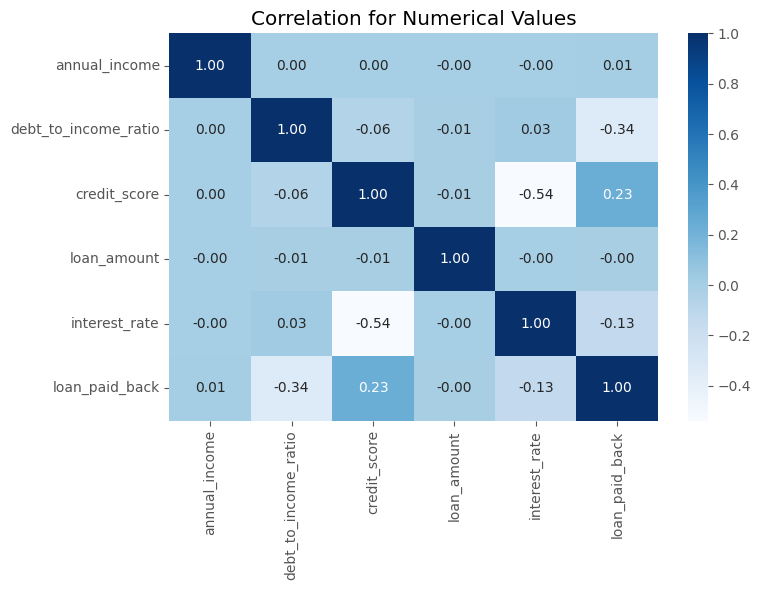

In [9]:
plt.figure(figsize=(8, 6))
correlation_matrix = train[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation for Numerical Values')
plt.tight_layout()
plt.show()

## Box Plots and KDE Plots

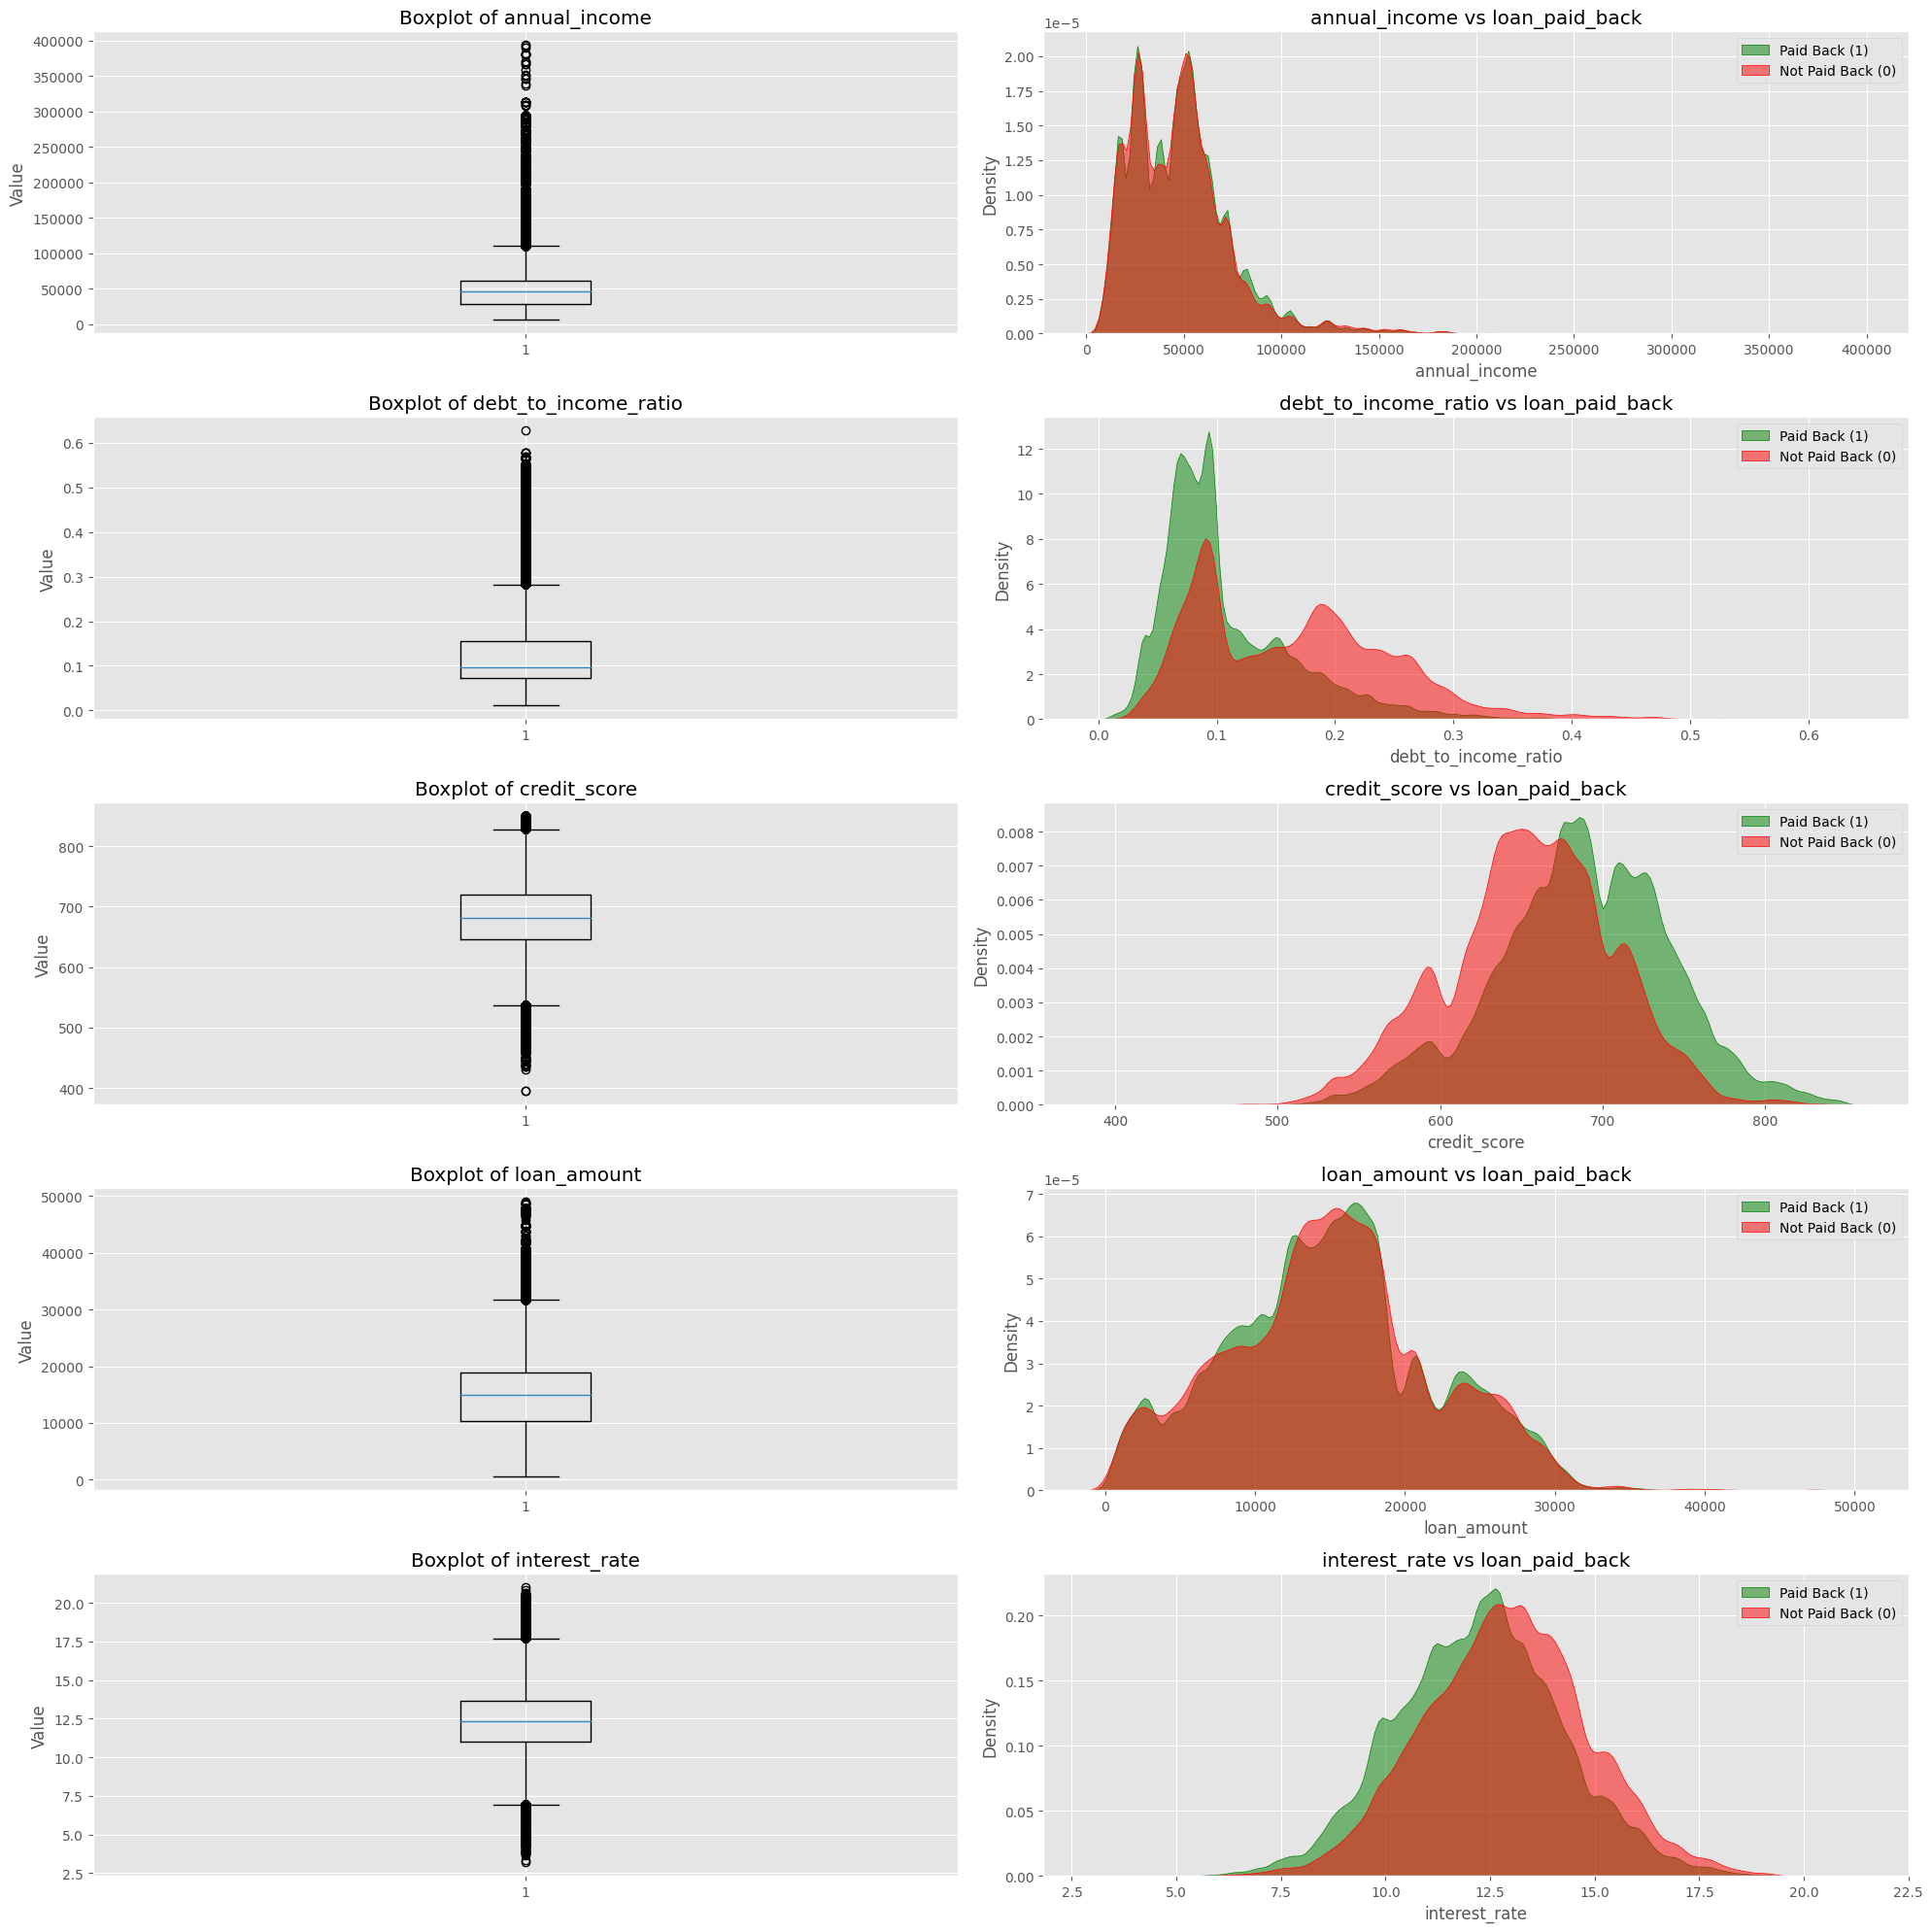

In [10]:
cols_to_plot = num_cols[:5]
fig, axes = plt.subplots(len(cols_to_plot), 2, figsize=(20, 20))  

for i, column in enumerate(cols_to_plot):
    # Boxplot (left)
    axes[i, 0].boxplot(train[column].dropna())
    axes[i, 0].set_title(f"Boxplot of {column}")
    axes[i, 0].set_ylabel("Value")
    
    # KDE plot (right) - split by loan_paid_back
    paid_back_1 = train[train['loan_paid_back'] == 1][column].dropna()
    paid_back_0 = train[train['loan_paid_back'] == 0][column].dropna()
    
    sns.kdeplot(data=paid_back_1, ax=axes[i, 1], fill=True, alpha=0.5, 
                label='Paid Back (1)', color='green')
    sns.kdeplot(data=paid_back_0, ax=axes[i, 1], fill=True, alpha=0.5, 
                label='Not Paid Back (0)', color='red')
    axes[i, 1].set_title(f"{column} vs loan_paid_back")
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel("Density")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [11]:
num_cols=num_cols.drop('loan_paid_back')

## Bar Graphs

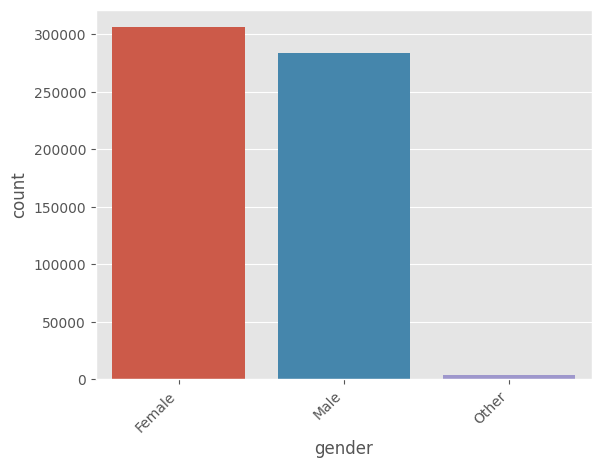

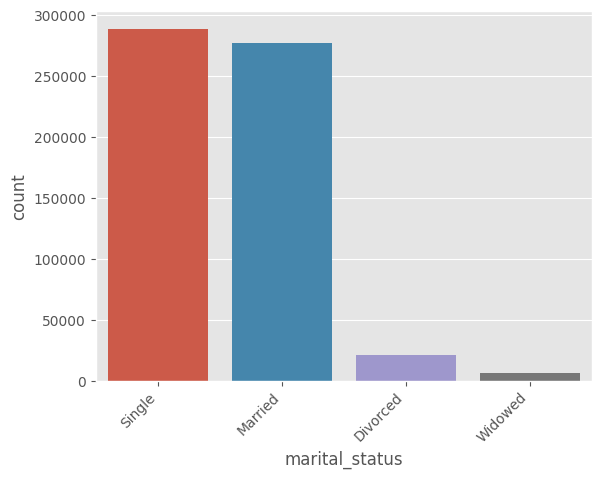

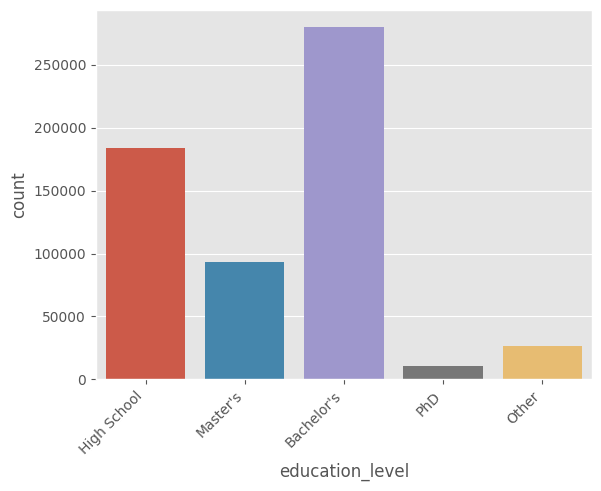

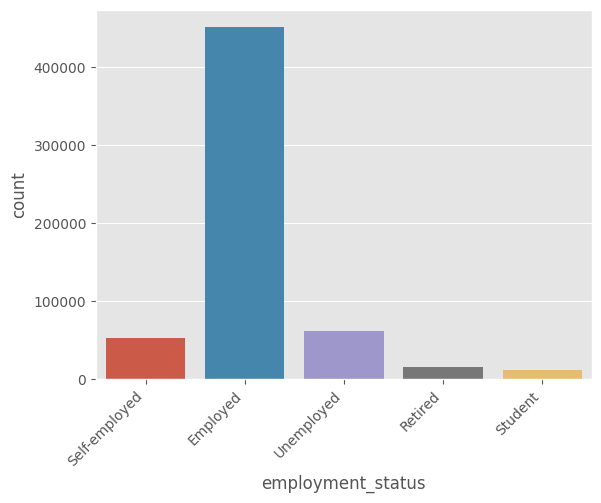

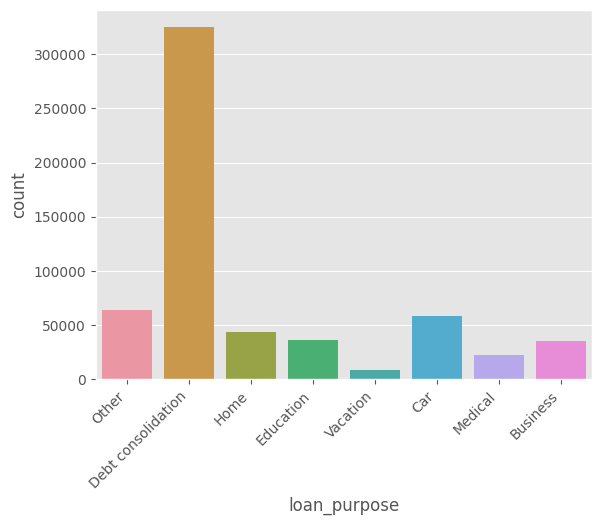

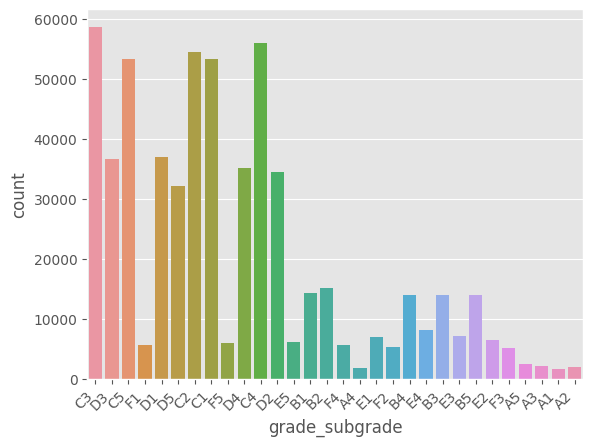

In [12]:
for i in cat_cols:
    sns.countplot(x=i, data=train)
    plt.xticks(rotation=45, ha='right')
    plt.show()

## Feature Engineering

In [13]:
def feature_engineer_loans(train):

    # Create copy of the Training Data
    train_eng = train.copy()
    # =========================
    # 1. INCOME BASED FEATURES
    # =========================
    
    train_eng['income_bracket'] = pd.cut(train_eng['annual_income'],
                                           bins = [0, 30000, 50000, 75000, 100000, np.inf],
                                           labels = ['<30K', '30-50K', '50-75K', '75-100k', '100K+'])
    
    train_eng['income_per_debt'] = train_eng['annual_income'] / train_eng['loan_amount']
    
    train_eng['monthly_income'] = train_eng['annual_income'] / 12
    
    train_eng['loan_to_income'] = train_eng['loan_amount'] / train_eng['annual_income']
    
    # ====================
    # 2. Credit Risk
    # ====================
    train_eng['credit_score-category'] = pd.cut(train_eng['credit_score'],
                                               bins = [0, 580, 669, 739, 799, 850],
                                               labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])
    
    # High debt-to-income flag
    train_eng['high_dti_flag'] = (train_eng['debt_to_income_ratio'] > 0.43).astype(int)
    
    train_eng['risk_score'] =(
        (train_eng['debt_to_income_ratio'] * 100) +
        ((850 - train_eng['credit_score']) / 10) +
        (train_eng['interest_rate'] * 5)
    )

    # ==========================
    # 3. Interest Rate Features
    # ==========================
    
    train_eng['interest_rate_category'] = pd.qcut(train_eng['interest_rate'],
                                                q = 3,
                                                labels = ['Low', 'Medium', 'High'])
    
    train_eng['interest_rate_deviation'] = train_eng['interest_rate'] - train_eng['interest_rate'].mean()
    
    assumed_term_years = 5
    train_eng['total_interest_cost'] = train_eng['loan_amount'] * (train_eng['interest_rate'] / 100) * assumed_term_years
    
    # ==============================
    # 4. Demographic Combinations
    # ==============================
    
    train_eng['edu_employment'] = train_eng['education_level'] + '_' + train_eng['employment_status']
    
    train_eng['marital_gender'] = train_eng['marital_status'] + '_' + train_eng['gender']
    
    education_order = {'High School' : 1, 'Bachelor(s)': 2, 'Master(s)' : 3, 'PhD': 4}
    train_eng['education_level_numeric'] = train_eng['education_level'].map(education_order)

    # ============================================
    # 5. LOAN AFFORDABILITY METRICS
    # ============================================
    
    # Estimated monthly payment (using standard loan formula)
    # M = P * [r(1+r)^n] / [(1+r)^n - 1]
    monthly_rate = train_eng['interest_rate'] / 100 / 12
    n_payments = 60  # 5 years
    train_eng['monthly_payment'] = train_eng['loan_amount'] * (
        (monthly_rate * (1 + monthly_rate)**n_payments) / 
        ((1 + monthly_rate)**n_payments - 1)
    )
    
    # Payment to income ratio
    train_eng['payment_to_income'] = train_eng['monthly_payment'] /train_eng['monthly_income']
    
    # Disposable income after loan payment
    train_eng['disposable_income'] = train_eng['monthly_income'] - train_eng['monthly_payment']
    
    
    # ============================================
    # 6. GRADE ANALYSIS
    # ============================================
    
    # Extract letter grade and subgrade
    train_eng['grade_letter'] = train_eng['grade_subgrade'].str[0]
    train_eng['grade_number'] = train_eng['grade_subgrade'].str[1:].astype(int)
    
    # Convert grade to numeric (A=7, B=6, ..., G=1)
    grade_map = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
    train_eng['grade_numeric'] = train_eng['grade_letter'].map(grade_map)
    
    # Fine-grained grade score (A1=7.5, A5=7.1, B1=6.5, etc.)
    train_eng['grade_score'] = train_eng['grade_numeric'] + (6 - train_eng['grade_number']) / 10
    
    
    # ============================================
    # 7. INTERACTION FEATURES
    # ============================================
    
    # Credit score × Income (affluent + good credit)
    train_eng['credit_income_interaction'] = train_eng['credit_score'] * train_eng['annual_income'] / 1000000
    train_eng
    # DTI × Interest rate (high risk combination)train_eng
    train_eng['dti_rate_risk'] = train_eng['debt_to_income_ratio'] * train_eng['interest_rate']
    
    
    # ============================================
    # 8. BINARY FLAGS
    # ============================================
    
    # High earner flag (top 25%)
    train_eng['high_earner'] = (train_eng['annual_income'] > train_eng['annual_income'].quantile(0.75)).astype(int)
    
    # Large loan flag (top 25%)
    train_eng['large_loan'] = (train_eng['loan_amount'] > train_eng['loan_amount'].quantile(0.75)).astype(int)
    
    # Excellent credit flag
    train_eng['excellent_credit'] = (train_eng['credit_score'] >= 750).astype(int)
    
    # Low interest rate flag (bottom 25%)
    train_eng['low_interest'] = (train_eng['interest_rate'] < train_eng['interest_rate'].quantile(0.25)).astype(int)
    
    
    # ============================================
    # 9. HANDLE MISSING/INFINITE VALUES
    # ============================================
    
    # Replace infinite values with NaN
    train_eng.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Fill NaN values in numeric columns with median
    numeric_cols = train_eng.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if train_eng[col].isna().any():
            train_eng[col].fillna(train_eng[col].median(), inplace=True)
    
    return train_eng
    


## Preprocessing 

In [14]:
train_final = feature_engineer_loans(train)
test_final = feature_engineer_loans(test)

def prepare_data(train_final, test_final, target='loan_paid_back'):
    """
    Prepare data for modeling
    """
    X = train_final.drop([target], axis=1, errors='ignore')
    y = train_final[target]
    X_test = test_final.copy()
    
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        if col in X_test.columns:
            X_test[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le
    
    return X, y, X_test, categorical_cols, label_encoders



# Making the Model and Model Tuning

## Creating the Two Models

In [15]:
def get_all_models():
    """
    Define all models to test
    """
    models = {
        'LightGBM_Baseline': LGBMClassifier(
            random_state=42,
            n_estimators=100,
            verbose=-1
        ),
        
        'LightGBM_Tuned': LGBMClassifier(
            random_state=42,
            n_estimators=500,
            learning_rate=0.05,
            max_depth=7,
            num_leaves=31,
            min_child_samples=20,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            verbose=-1
        )
    }
    return models

## Training and Evaluating the Models

In [16]:
def train_and_evaluate_all_models(X, y, test_size=0.2):
    """
    Train all models and compare their performance
    """
    print("=" * 70)
    print("TRAINING AND EVALUATING ALL MODELS")
    print("=" * 70)
    print()
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print()
    
    models = get_all_models()
    results = []
    trained_models = {}
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        try:
            model.fit(X_train, y_train)
            
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            
            roc_auc = roc_auc_score(y_val, y_pred_proba)
            
            results.append({
                'Model': model_name,
                'ROC-AUC': roc_auc
            })
            
            trained_models[model_name] = model
            
            print(f"ROC-AUC: {roc_auc:.4f}")
            print()
            
        except Exception as e:
            print(f"Error training {model_name}: {str(e)}")
            print()
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)
    
    return results_df, trained_models, X_val, y_val

## Cross - Validation

In [17]:
def cross_validate_all_models(X, y, cv=5):
    """
    Perform cross-validation on all models
    """
    print("=" * 70)
    print(f"CROSS-VALIDATION ({cv}-FOLD) FOR ALL MODELS")
    print("=" * 70)
    print()
    
    models = get_all_models()
    cv_results = []
    
    for model_name, model in models.items():
        print(f"Cross-validating {model_name}...")
        
        try:
            skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
            
            cv_scores = cross_val_score(
                model, X, y, 
                cv=skf, 
                scoring='roc_auc',
                n_jobs=-1
            )
            
            cv_results.append({
                'Model': model_name,
                'Mean_ROC-AUC': cv_scores.mean(),
                'Std_ROC-AUC': cv_scores.std(),
                'Min_ROC-AUC': cv_scores.min(),
                'Max_ROC-AUC': cv_scores.max()
            })
            
            print(f"Mean ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
            print()
            
        except Exception as e:
            print(f"Error cross-validating {model_name}: {str(e)}")
            print()
    
    cv_results_df = pd.DataFrame(cv_results)
    cv_results_df = cv_results_df.sort_values('Mean_ROC-AUC', ascending=False).reset_index(drop=True)
    
    return cv_results_df

## Visualizations

In [18]:
def plot_model_comparison(results_df, cv_results_df=None):
    """
    Visualize model comparison
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1 = axes[0]
    sns.barplot(
        data=results_df,
        x='ROC-AUC',
        y='Model',
        palette='viridis',
        ax=ax1
    )
    ax1.set_title('Model Performance on Validation Set', fontsize=14, fontweight='bold')
    ax1.set_xlabel('ROC-AUC Score', fontsize=12)
    ax1.set_ylabel('Model', fontsize=12)
    
    for i, v in enumerate(results_df['ROC-AUC']):
        ax1.text(v + 0.01, i, f'{v:.4f}', va='center')
    
    if cv_results_df is not None:
        ax2 = axes[1]
        ax2.barh(cv_results_df['Model'], cv_results_df['Mean_ROC-AUC'], 
                 xerr=cv_results_df['Std_ROC-AUC'], color='steelblue', alpha=0.7)
        ax2.set_title('Model Performance (Cross-Validation)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Mean ROC-AUC Score', fontsize=12)
        ax2.set_ylabel('Model', fontsize=12)
        
        for i, (mean, std) in enumerate(zip(cv_results_df['Mean_ROC-AUC'], cv_results_df['Std_ROC-AUC'])):
            ax2.text(mean + 0.01, i, f'{mean:.4f}±{std:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plot confusion matrix for a model
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_feature_importance(model, X, model_name, top_n=20):
    """
    Plot feature importance (for tree-based models)
    """
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 8))
        sns.barplot(
            data=importance_df.head(top_n),
            x='importance',
            y='feature',
            palette='viridis'
        )
        plt.title(f'Top {top_n} Feature Importances - {model_name}', fontsize=14, fontweight='bold')
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        return importance_df
    else:
        print(f"{model_name} does not have feature_importances_ attribute")
        return None

## Pipeline

In [19]:
def run_complete_pipeline(train_final, test_final, target='loan_paid_back', use_cv=True):
    """
    Run complete model comparison pipeline
    """
    print("\n" + "=" * 70)
    print("STARTING COMPLETE MODEL COMPARISON PIPELINE")
    print("=" * 70 + "\n")
    
    print("Step 1: Preparing data...")
    X, y, X_test, categorical_cols, label_encoders = prepare_data(train_final, test_final, target)
    print(f"Data prepared: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Target distribution: {y.value_counts().to_dict()}")
    print()
    
    print("Step 2: Training all models on validation split...")
    results_df, trained_models, X_val, y_val = train_and_evaluate_all_models(X, y)
    
    cv_results_df = None
    if use_cv:
        print("Step 3: Cross-validation for all models...")
        cv_results_df = cross_validate_all_models(X, y, cv=5)
    
    print("=" * 70)
    print("VALIDATION SET RESULTS")
    print("=" * 70)
    print(results_df.to_string(index=False))
    print()
    
    if cv_results_df is not None:
        print("=" * 70)
        print("CROSS-VALIDATION RESULTS")
        print("=" * 70)
        print(cv_results_df.to_string(index=False))
        print()
    
    best_model_name = results_df.iloc[0]['Model']
    best_score = results_df.iloc[0]['ROC-AUC']
    best_model = trained_models[best_model_name]
    
    print("=" * 70)
    print(f"BEST MODEL: {best_model_name}")
    print(f"Validation ROC-AUC: {best_score:.4f}")
    print("=" * 70)
    print()
    
    print("Step 4: Generating visualizations...")
    plot_model_comparison(results_df, cv_results_df)
    
    y_pred = best_model.predict(X_val)
    plot_confusion_matrix(y_val, y_pred, best_model_name)
    
    importance_df = plot_feature_importance(best_model, X, best_model_name, top_n=20)
    
    print("Step 5: Retraining best model on full training data...")
    best_model_final = get_all_models()[best_model_name]
    best_model_final.fit(X, y)
    print("Model retrained")
    print()
    
    print("Step 6: Making predictions on test set...")
    test_predictions = best_model_final.predict(X_test)
    test_predictions_proba = best_model_final.predict_proba(X_test)[:, 1]
    print("Predictions complete")
    print()
    
    print("=" * 70)
    print("PIPELINE COMPLETE!")
    print("=" * 70)
    
    return {
        'best_model': best_model_final,
        'best_model_name': best_model_name,
        'predictions': test_predictions,
        'predictions_proba': test_predictions_proba,
        'results_df': results_df,
        'cv_results_df': cv_results_df,
        'feature_importance': importance_df,
        'all_trained_models': trained_models
    }

# Submission


STARTING COMPLETE MODEL COMPARISON PIPELINE

Step 1: Preparing data...
Data prepared: 593994 samples, 37 features
Target distribution: {1.0: 474494, 0.0: 119500}

Step 2: Training all models on validation split...
TRAINING AND EVALUATING ALL MODELS

Training set: 475195 samples
Validation set: 118799 samples

Training LightGBM_Baseline...
ROC-AUC: 0.9188

Training LightGBM_Tuned...
ROC-AUC: 0.9210

Step 3: Cross-validation for all models...
CROSS-VALIDATION (5-FOLD) FOR ALL MODELS

Cross-validating LightGBM_Baseline...
Mean ROC-AUC: 0.9191 (+/- 0.0006)

Cross-validating LightGBM_Tuned...
Mean ROC-AUC: 0.9213 (+/- 0.0007)

VALIDATION SET RESULTS
            Model  ROC-AUC
   LightGBM_Tuned 0.921000
LightGBM_Baseline 0.918791

CROSS-VALIDATION RESULTS
            Model  Mean_ROC-AUC  Std_ROC-AUC  Min_ROC-AUC  Max_ROC-AUC
   LightGBM_Tuned      0.921336     0.000694     0.920426      0.92242
LightGBM_Baseline      0.919147     0.000605     0.918431      0.92025

BEST MODEL: LightGBM_Tune

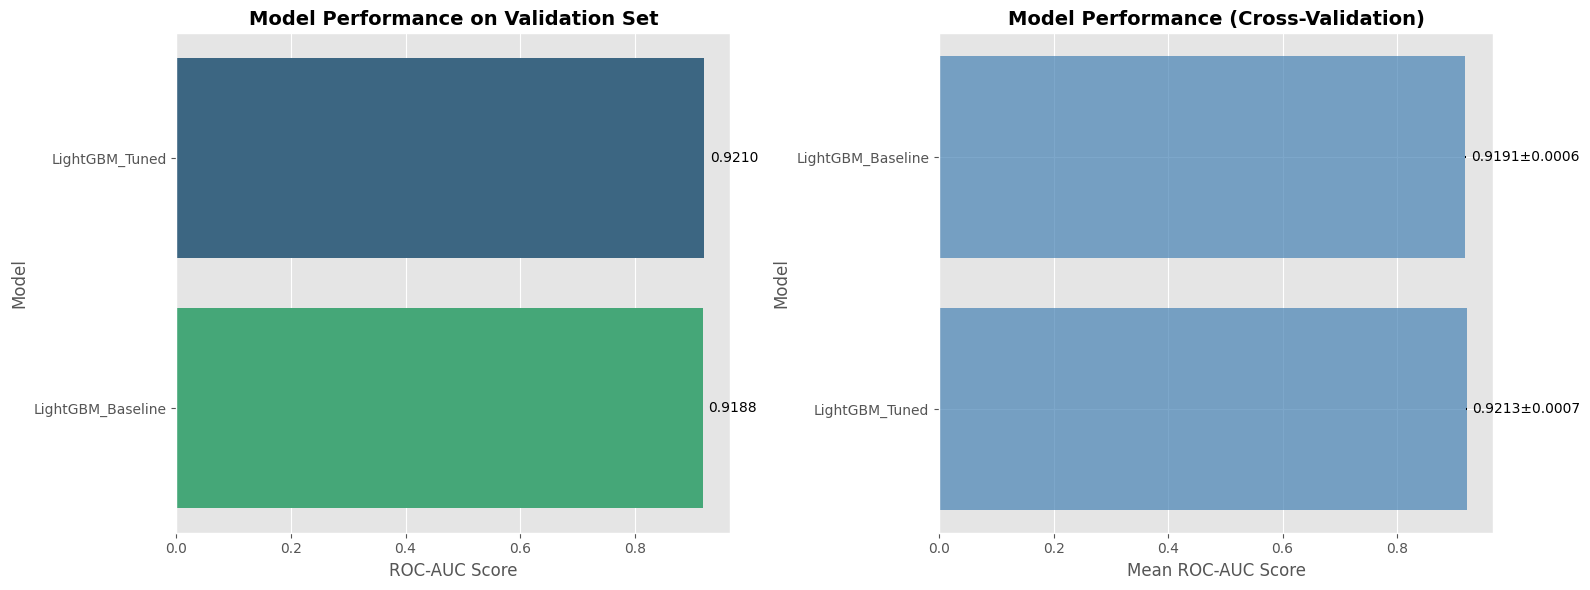

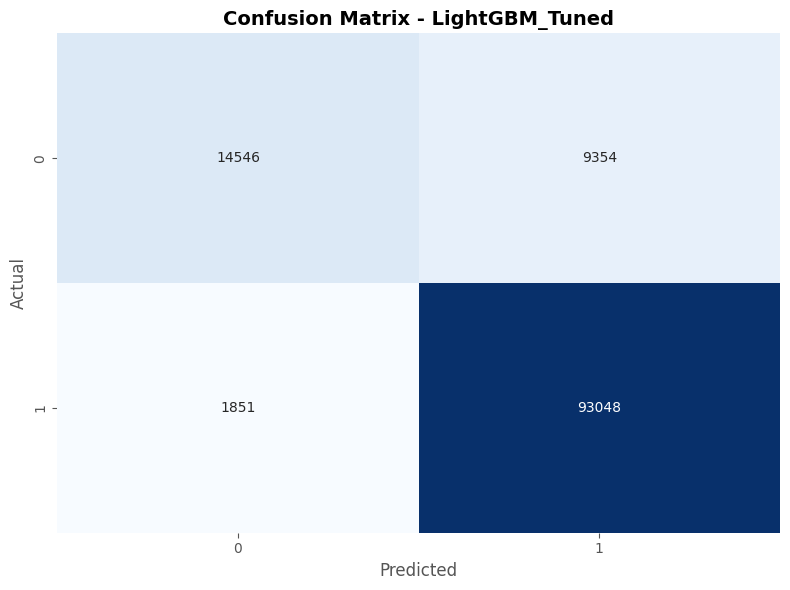

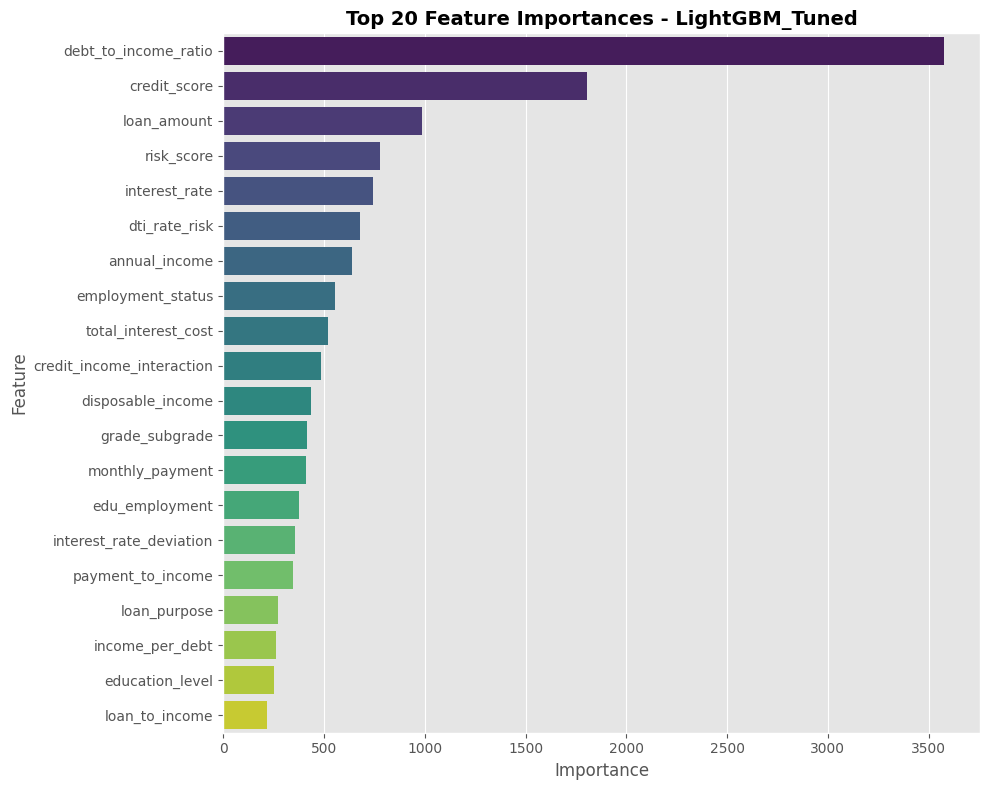

Step 5: Retraining best model on full training data...
Model retrained

Step 6: Making predictions on test set...
Predictions complete

PIPELINE COMPLETE!

Creating submission file...
Submission file created: submission.csv


In [20]:
# Train Dataset
train_df = pd.read_csv('../input/playground-series-s5e11/train.csv')
# Test Dataset
test_df = pd.read_csv('../input/playground-series-s5e11/test.csv')

test_ids = test_df['id'].copy()

# Running the Complete Pipeline
pipeline_results = run_complete_pipeline(
    train_final, 
    test_final, 
    target='loan_paid_back',
    use_cv=True  
)

# Access results
best_model = pipeline_results['best_model']
predictions = pipeline_results['predictions']
results_df = pipeline_results['results_df']

print("\n" + "=" * 70)
print("Creating submission file...")
# Create submission
submission = pd.DataFrame({
    "id" : test_df["id"],
    "loan_paid_back" : predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")
print("=" * 70)